In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [3]:
import optax

In [4]:
from tqdm import tqdm

In [5]:
from QCBM import QCBM, KLDivergence, MMD

## Mixture of Gaussian

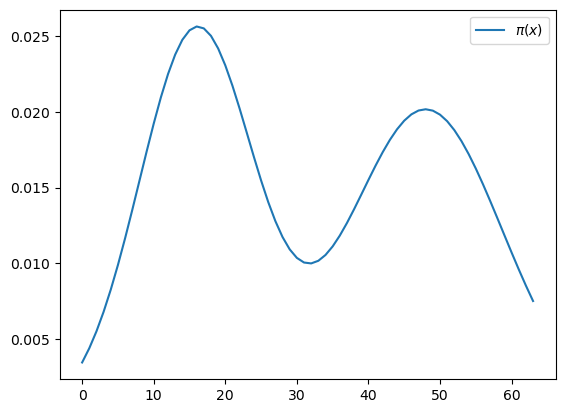

In [6]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(1 / 4) * x_max, (3 / 4) * x_max]
sigmas = [x_max / 8, x_max/6]
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

In [ ]:
def QCBM_n_qubits_MMD(n_layers = 4, n_qubits = 5):
    tol = 1e-9
    x_max = 2**n_qubits
    x_input = np.arange(x_max)
    mus = [(1 / 4) * x_max, (3 / 4) * x_max]
    sigmas = [x_max / 8, x_max/6]
    data = mixture_gaussian_pdf(x_input, mus, sigmas)

    dev = qml.device("default.qubit", wires=n_qubits)

    wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
    weights = np.random.random(size=wshape)

    @qml.qnode(dev)
    def circuit(weights):
        qml.StronglyEntanglingLayers(
            weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
        )
        return qml.probs()


    jit_circuit = jax.jit(circuit)

    bandwidth = jnp.array([0.25, 60])
    space = jnp.arange(2**n_qubits)

    mmd = MMD(bandwidth, space)
    qcbm = QCBM(jit_circuit, mmd, data)

    opt = optax.adam(learning_rate=0.1)
    opt_state = opt.init(weights)

    history = []
    divs = []
    n_iterations = 1000

    lowest_kl = 10000
    iter = 0

    for i in tqdm(range(n_iterations)):
        (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
        updates, opt_state = opt.update(grads, opt_state)
        weights = optax.apply_updates(weights, updates)
        kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
        # weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

        # if i % 10 == 0:
        #     print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

        if kl_div < tol:
            break

        if kl_div < lowest_kl:
            lowest_kl = kl_div

        history.append(loss_val)
        divs.append(kl_div)

        iter += 1

    qcbm_probs = qcbm.circ(weights)

    plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
    plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

    plt.xlabel("Samples")
    plt.ylabel("Prob. Distribution")
    plt.title(f'Result: {n_qubits} qubits, {n_layers} layers, loss = MMD')

    plt.savefig(f'Results/StronglyEntangled/n_qubits_vs_n_layers/MMD/Results_{n_qubits}qubits_{n_layers}layers_MMD')

    plt.legend()
    plt.show()

    # save lowest kl-divergence

    return history, divs, lowest_kl, iter

In [ ]:
n_layers = [5,10,20,30,40,50]
n_qubits = [4,5,6,7,8,9]

nqubits_to_nlayers_kl_divs = []
nqubits_to_nlayers_iter = []

for qubits in n_qubits:
    temp_lowest_kl = []
    temp_iter = []
    for layer in n_layers:
        history, divs, lowest_kl, iter = QCBM_n_qubits_MMD(n_layers = layer, n_qubits = qubits)
        # save history
        np.save(f"Experiments/MMD_More_Qubits/loss_qubits{qubits}_layers{layer}.npy", history)
        # save divs
        np.save(f"Experiments/MMD_More_Qubits/kl_divs_qubits{qubits}_layers{layer}.npy", history)
        # save lowest_kl
        temp_lowest_kl.append(lowest_kl)
        temp_iter.append(iter)
    nqubits_to_nlayers_kl_divs.append(temp_lowest_kl)
    nqubits_to_nlayers_iter.append(temp_iter)

In [ ]:
for i, row in enumerate(nqubits_to_nlayers_kl_divs):
    plt.plot(n_layers, row, label=f'N_Qubits {i+4}', marker='o')

# Adding labels, title, and legend
plt.xlabel("N_layers")
plt.ylabel("KL_Divs")
plt.title("N Qubits vs N Layers Convergence")
plt.yscale("log")  # Log scale for better visualization of small values
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.savefig(f"Analysis/N_QubitsvsN_Layers_StatisticalDistance_Convergence_MMD")
plt.show()

In [ ]:
for i, row in enumerate(nqubits_to_nlayers_iter):
    plt.plot(n_layers, row, label=f'N_Qubits {i+4}', marker='o')

# Adding labels, title, and legend
plt.xlabel("N_layers")
plt.ylabel("Iter to Tolerance")
plt.title("Training time N Qubits vs N Layers")
#plt.yscale("log")  # Log scale for better visualization of small values
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# plt.savefig(f"Analysis/N_QubitsvsN_Layers_NumIters_Convergence_MMD")
plt.show()

## KL Divergence

In [9]:
def QCBM_n_qubits_KL_div(n_layers = 4, n_qubits = 5):
    tol = 1e-9
    x_max = 2**n_qubits
    x_input = np.arange(x_max)
    mus = [(1 / 4) * x_max, (3 / 4) * x_max]
    sigmas = [x_max / 8, x_max/6]
    data = mixture_gaussian_pdf(x_input, mus, sigmas)

    dev = qml.device("default.qubit", wires=n_qubits)

    wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
    weights = np.random.random(size=wshape)

    @qml.qnode(dev)
    def circuit(weights):
        qml.StronglyEntanglingLayers(
            weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
        )
        return qml.probs()


    jit_circuit = jax.jit(circuit)

    bandwidth = jnp.array([0.25, 60])
    space = jnp.arange(2**n_qubits)

    loss = KLDivergence()
    qcbm = QCBM(jit_circuit, loss, data)

    opt = optax.adam(learning_rate=0.1)
    opt_state = opt.init(weights)

    history = []
    divs = []
    n_iterations = 1000

    lowest_kl = 10000

    for i in tqdm(range(n_iterations)):
        (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
        updates, opt_state = opt.update(grads, opt_state)
        weights = optax.apply_updates(weights, updates)
        kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
        # weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

        # if i % 10 == 0:
        #     print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

        if kl_div < tol:
            break

        if kl_div < lowest_kl:
            lowest_kl = kl_div

        history.append(loss_val)
        divs.append(kl_div)

    qcbm_probs = qcbm.circ(weights)

    plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
    plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

    plt.xlabel("Samples")
    plt.ylabel("Prob. Distribution")
    plt.title(f'Result: {n_qubits} qubits, {n_layers} layers, loss = KL_div')

    plt.savefig(f'Results/StronglyEntangled/n_qubits_vs_n_layers/KL_Div/Results_{n_qubits}qubits_{n_layers}layers_KL_div')

    plt.legend()
    plt.show()

    # save lowest kl-divergence

    return history, divs, lowest_kl

 18%|█▊        | 179/1000 [00:02<00:12, 63.67it/s] 


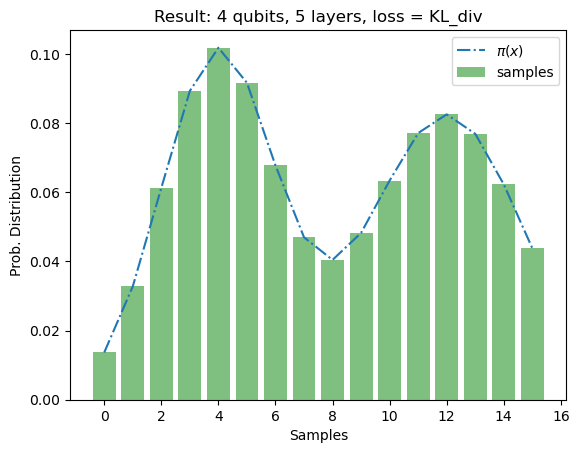

 55%|█████▍    | 546/1000 [00:10<00:08, 54.33it/s]


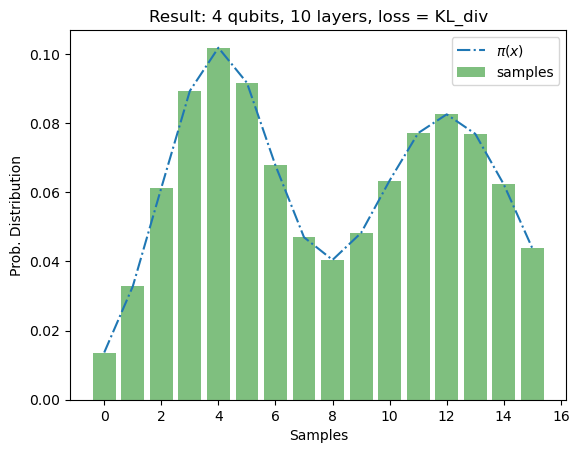

 57%|█████▋    | 569/1000 [00:22<00:16, 25.58it/s]


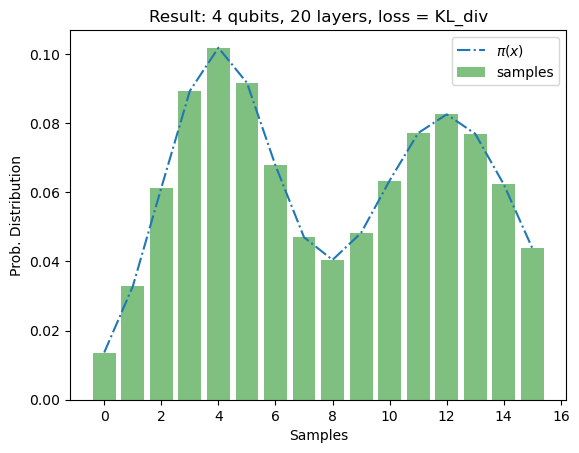

 53%|█████▎    | 531/1000 [00:37<00:33, 14.11it/s]


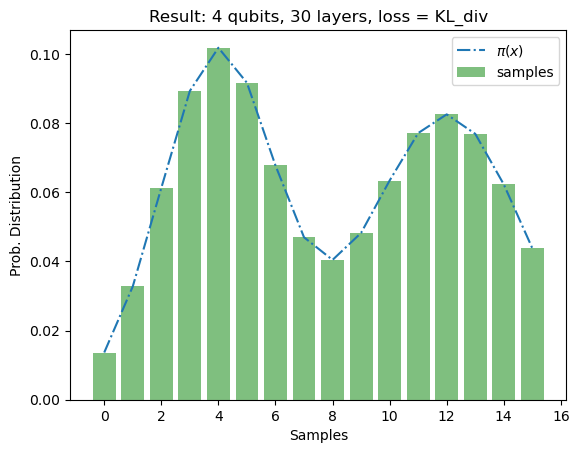

  0%|          | 3/1000 [00:13<57:27,  3.46s/it]  

In [ ]:
n_layers = [5,10,20,30,40,50]
n_qubits = [4,5,6,7,8,9]

nqubits_to_nlayers_KL = []
nqubits_to_nlayers_iterKL = []

for qubits in n_qubits:
    temp_lowest_kl = []
    temp_iter = []
    for layer in n_layers:
        history, divs, lowest_kl = QCBM_n_qubits_KL_div(n_layers = layer, n_qubits = qubits)
        # save history
        np.save(f"Experiments/KL_More_Qubits/loss_qubits{qubits}_layers{layer}.npy", history)
        # save divs
        np.save(f"Experiments/KL_More_Qubits/kl_divs_qubits{qubits}_layers{layer}.npy", history)
        # save lowest_kl
        temp_lowest_kl.append(lowest_kl)
        temp_iter.append(iter)
    nqubits_to_nlayers_KL.append(temp_lowest_kl)
    nqubits_to_nlayers_iterKL.append(temp_iter)

In [ ]:
for i, row in enumerate(nqubits_to_nlayers_KL):
    plt.plot(n_layers, row, label=f'N_Qubits {i+4}', marker='o')

# Adding labels, title, and legend
plt.xlabel("N_layers")
plt.ylabel("KL_Divs")
plt.title("N Qubits vs N Layers Convergence")
plt.yscale("log")  # Log scale for better visualization of small values
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig('Analysis/N_QubitsvsN_Layers_StatistcalDistance_Convergence_KL_divs.png')
plt.show()

In [ ]:
for i, row in enumerate(nqubits_to_nlayers_iterKL):
    plt.plot(n_layers, row, label=f'N_Qubits {i+4}', marker='o')

# Adding labels, title, and legend
plt.xlabel("N_layers")
plt.ylabel("KL_Divs")
plt.title("N Qubits vs N Layers Convergence")
plt.yscale("log")  # Log scale for better visualization of small values
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig('Analysis/N_QubitsvsN_Layers_NumIters_Convergence_KL_divs.png')
plt.show()